In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
import pandas as pd

In [3]:
from datatools.wfip2 import read_dir

# TTU 200-m Tower Data (2013-11-08 to 09)
downloaded from DAP (https://a2e.energy.gov/data/mmc/tower.z01.00)

In [4]:
# on Peregrine
datadir = '/projects/mmc/SWIFTRegion/8Nov2013/tower.z01.00'

In [5]:
heights_ft = [3, 8, 13, 33, 55, 155, 245, 382, 519, 656]
heights = [0.9, 2.4, 4.0, 10.1, 16.8, 47.3, 74.7, 116.5, 158.2, 200.0]  # [m]

In [6]:
height_suffixes = ['_{:d}ft'.format(z) for z in heights_ft]
print(height_suffixes)

['_3ft', '_8ft', '_13ft', '_33ft', '_55ft', '_155ft', '_245ft', '_382ft', '_519ft', '_656ft']


## 1. Combine all data into single dataframe
Data at 50 Hz:
* u,v,w: velocity components (west-east, south-north, vertical) [m/s]
* p: barometric pressure [kPa]
* T: actual air temperature [K]
* Tv: virtual temperature [K]
* RH: relative humidity [%]

In [7]:
varnames = ['unorth', 'vwest', 'w', 'p', 't', 'tsonic', 'rh']

In [8]:
def read_ttu_tower(fpath):
    """Read csv file from TTU 200-m tower station measurement package"""
    return pd.read_csv(fpath, header=4, parse_dates={'datetime':[0]})

In [9]:
# takes ~5 min
%time df0 = read_dir(datadir, reader=read_ttu_tower, file_filter='tower.z01.00*', ext='dat', verbose=True)

Reading /projects/mmc/SWIFTRegion/8Nov2013/tower.z01.00/tower.z01.00.20131108.000000.ttu200m.dat
Reading /projects/mmc/SWIFTRegion/8Nov2013/tower.z01.00/tower.z01.00.20131108.010000.ttu200m.dat
Reading /projects/mmc/SWIFTRegion/8Nov2013/tower.z01.00/tower.z01.00.20131108.020000.ttu200m.dat
Reading /projects/mmc/SWIFTRegion/8Nov2013/tower.z01.00/tower.z01.00.20131108.030000.ttu200m.dat
Reading /projects/mmc/SWIFTRegion/8Nov2013/tower.z01.00/tower.z01.00.20131108.040000.ttu200m.dat
Reading /projects/mmc/SWIFTRegion/8Nov2013/tower.z01.00/tower.z01.00.20131108.050000.ttu200m.dat
Reading /projects/mmc/SWIFTRegion/8Nov2013/tower.z01.00/tower.z01.00.20131108.060000.ttu200m.dat
Reading /projects/mmc/SWIFTRegion/8Nov2013/tower.z01.00/tower.z01.00.20131108.070000.ttu200m.dat
Reading /projects/mmc/SWIFTRegion/8Nov2013/tower.z01.00/tower.z01.00.20131108.080000.ttu200m.dat
Reading /projects/mmc/SWIFTRegion/8Nov2013/tower.z01.00/tower.z01.00.20131108.090000.ttu200m.dat
Reading /projects/mmc/SWIFTReg

In [10]:
df0.head()

,datetime,unorth_3ft,vwest_3ft,w_3ft,ustream_3ft,vcross_3ft,wdir_3ft,tsonic_3ft,t_3ft,p_3ft,...,unorth_656ft,vwest_656ft,w_656ft,ustream_656ft,vcross_656ft,wdir_656ft,tsonic_656ft,t_656ft,p_656ft,rh_656ft
0,2013-11-08 00:00:00.000,-2.638194,-0.138231,0.040203,2.640161,-0.093404,177.000664,61.26800,52.95920,90.854775,...,-9.938568,1.046880,0.439199,9.992516,0.143990,186.013081,59.216,52.8440,88.709152,25.664
1,2013-11-08 00:00:00.020,-2.539588,-0.093870,0.050752,2.538049,-0.128957,177.883158,61.17799,52.95560,90.852744,...,-9.869068,1.226425,0.468106,9.944888,-0.042553,187.083807,59.180,52.8764,88.713961,25.698
2,2013-11-08 00:00:00.040,-2.520115,-0.117907,0.131027,2.520755,-0.103306,177.321287,61.30400,52.89799,90.849154,...,-9.806546,1.212932,0.439649,9.881204,-0.036601,187.050874,59.198,52.8332,88.709152,25.658
3,2013-11-08 00:00:00.060,-2.568197,-0.158572,0.030845,2.572215,-0.067010,176.466796,61.44800,52.94839,90.853556,...,-9.846065,1.282371,0.407769,9.928711,-0.100841,187.420548,59.252,52.7828,88.706342,25.658
4,2013-11-08 00:00:00.080,-2.534399,-0.179798,0.041212,2.540406,-0.042905,175.942068,61.53800,53.04920,90.859957,...,-9.822578,1.268828,0.518518,9.903778,-0.090191,187.360406,59.252,52.7576,88.702346,25.634


Now, convert to stacked format: replace height-specific columns with general varnames, add a 'height' data column. Units conversion happens here. 

**Note: `unorth` is velocity *from* the north, etc.**

In [11]:
%%time
dflist = []
for z, suffix in zip(heights, height_suffixes):
    columns = [var+suffix for var in varnames]
    namedict = dict(zip(columns,varnames))
    dfz = df0[['datetime']+columns].rename(namedict,axis=1)
    dfz['height'] = z
    dflist.append(dfz)
df = pd.concat(dflist)

CPU times: user 57.1 s, sys: 13.6 s, total: 1min 10s
Wall time: 4.06 s


In [12]:
df['u'] = df['vwest']
df['v'] = -df['unorth']
df['T'] = 5./9.*(df['t']-32.0) + 273.15
df['Tv'] = 5./9.*(df['tsonic']-32.0) + 273.15
df['RH'] = df['rh']
df = df[['datetime','height','u','v','w','p','T','Tv','RH']]

In [13]:
df = df.set_index('datetime')

In [14]:
df.head()

,height,u,v,w,p,T,Tv,RH
datetime,,,,,,,,
2013-11-08 00:00:00.000,0.9,-0.138231,2.638194,0.040203,90.854775,284.794000,289.410000,26.186
2013-11-08 00:00:00.020,0.9,-0.093870,2.539588,0.050752,90.852744,284.792000,289.359994,26.190
2013-11-08 00:00:00.040,0.9,-0.117907,2.520115,0.131027,90.849154,284.759994,289.430000,26.144
2013-11-08 00:00:00.060,0.9,-0.158572,2.568197,0.030845,90.853556,284.787994,289.510000,26.138
2013-11-08 00:00:00.080,0.9,-0.179798,2.534399,0.041212,90.859957,284.844000,289.560000,26.198


## 2. Calculate potential temperature

In [15]:
p0 = 100.0 # kPa
R_cp = 0.286

In [16]:
# df['thetav'] = df['Tv'] * (p0 / df['p'])**R_cp

calculate virtual temperature... (from Kelley2016)

In [17]:
# saturation vapor pressure (Eqn. 2.21)
e_s = 0.611 * np.exp(5423.*(1./273. - 1./df['T'])) # [kPa]

In [18]:
# saturation mixing ratio (Eqn. 2.20)
r_s = 0.622 * e_s / (df['p'] - e_s)

In [19]:
# virtual temperature (Eqn. 2.19)
Tv = df['T']*(1 + 0.61*r_s*df['RH']/100.0)

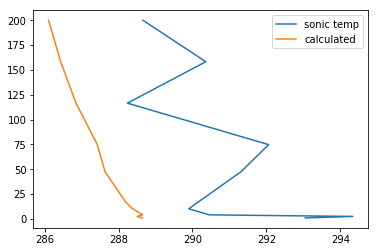

In [20]:
sel = (df.index == '2013-11-08 22:30:00')
plt.plot(df.loc[sel,'Tv'],heights,label='sonic temp')
plt.plot(Tv.loc[sel],heights,label='calculated')
plt.legend(loc='best')

In [21]:
# virtual potential temperature (Eqn. 2.18)
df['thetav'] = Tv * (p0 / df['p'])**R_cp

## 3. Save 1-Hz data

In [22]:
%time df_1Hz = df.pivot(columns='height',values=['u','v','w','thetav']).resample('1s').mean().stack()

CPU times: user 1min 26s, sys: 15.9 s, total: 1min 42s
Wall time: 58.3 s


In [23]:
%time df_1Hz.to_csv('data/TTU_tower_20131108_1Hz.csv')

CPU times: user 24.1 s, sys: 650 ms, total: 24.8 s
Wall time: 24.4 s


## 4. Calculate 10-min statistics

In [24]:
period = '10min'

In [25]:
# calculate means <U_i>
%time df_10min = df.pivot(columns='height',values=['u','v','w','thetav']).resample(period).mean().stack()

CPU times: user 1min 15s, sys: 11.4 s, total: 1min 27s
Wall time: 1min 6s


In [26]:
# calculate variances <u_i' u_i'>
%time variances = df.pivot(columns='height',values=['u','v','w']).resample(period).var().stack()

CPU times: user 1min 19s, sys: 10.8 s, total: 1min 29s
Wall time: 1min 8s


In [27]:
%%time
# calculate products
dfprod = pd.DataFrame(index=df.index)
dfprod['height'] = df['height']
dfprod['uu'] = df['u'] * df['u'] # SANITY CHECK
dfprod['vv'] = df['v'] * df['v'] # SANITY CHECK
dfprod['ww'] = df['w'] * df['w'] # SANITY CHECK
dfprod['uv'] = df['u'] * df['v']
dfprod['uw'] = df['u'] * df['w']
dfprod['vw'] = df['v'] * df['w']
dfprod['tw'] = df['thetav'] * df['w']

CPU times: user 13.8 s, sys: 3.85 s, total: 17.6 s
Wall time: 750 ms


In [28]:
# calculate means <U_i U_j>
%time prod_mean = dfprod.pivot(columns='height').resample(period).mean().stack()

CPU times: user 1min 32s, sys: 22.2 s, total: 1min 54s
Wall time: 1min 11s


In [29]:
# SANITY CHECK: two approaches should be equivalent
# i.e.,
#   var(u) == mean(u*u) - mean(u)*mean(u)
err = np.abs(prod_mean['uu'] - df_10min['u']*df_10min['u'] - variances['u']); print(np.max(err),np.mean(err))
err = np.abs(prod_mean['vv'] - df_10min['v']*df_10min['v'] - variances['v']); print(np.max(err),np.mean(err))
err = np.abs(prod_mean['ww'] - df_10min['w']*df_10min['w'] - variances['w']); print(np.max(err),np.mean(err))

0.0006298920702754174 2.1241515676371327e-05
0.00018028618322318835 2.1217453602497798e-05
0.0003289056164987869 9.127059337561634e-06


In [30]:
%%time
# calculate Reynolds stresses <u_i' u_j'> = <U_i U_j> - <U_i><U_j>
df_10min['uu'] = variances['u']
df_10min['vv'] = variances['v']
df_10min['ww'] = variances['w']
df_10min['uv'] = prod_mean['uv'] - df_10min['u']*df_10min['v']
df_10min['uw'] = prod_mean['uw'] - df_10min['u']*df_10min['w']
df_10min['vw'] = prod_mean['vw'] - df_10min['v']*df_10min['w']
df_10min['tw'] = prod_mean['tw'] - df_10min['thetav']*df_10min['w']

CPU times: user 12 ms, sys: 1.06 ms, total: 13.1 ms
Wall time: 12.4 ms


In [31]:
df_10min.head()

u         v         w      thetav        uu  \
datetime   height                                                       
2013-11-08 0.9    -0.252493  2.871292 -0.051643  292.658722  0.106279   
           2.4    -0.248722  3.382154 -0.206384  292.816727  0.118248   
           4.0    -0.226337  3.390344 -0.109889  293.121340  0.117431   
           10.1   -0.547638  4.537476 -0.014839  293.469409  0.109090   
           16.8   -0.232308  5.424099 -0.036734  293.747246  0.098872   

                         vv        ww        uv        uw        vw        tw  
datetime   height                                                              
2013-11-08 0.9     0.180421  0.066140 -0.014938  0.000003 -0.031162 -0.010918  
           2.4     0.185434  0.091704 -0.017369 -0.006292 -0.051677  0.021208  
           4.0     0.212125  0.147491  0.036626  0.047150 -0.010662  0.086992  
           10.1    0.252866  0.120394  0.020934  0.012241 -0.041621  0.001540  
           16.8    0.261779  0.099571  0.028755  0.009168 -0.040850  0.004686

In [32]:
df_10min.to_csv('data/TTU_tower_20131108_10min.csv')

## 5. Check profiles

In [33]:
df_10min = df_10min.reset_index(1)

Text(0.5,1,'color reference')

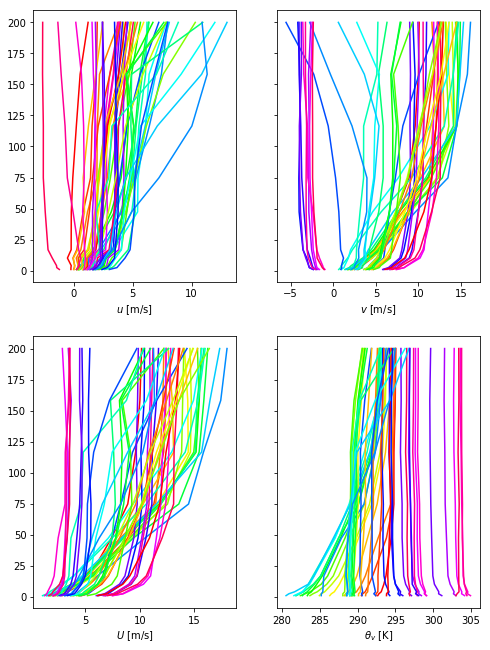

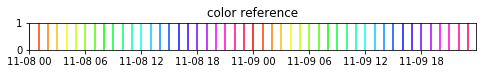

In [34]:
fig,ax = plt.subplots(nrows=2,ncols=2,sharey=True,figsize=(8,11))
fig2,ax2 = plt.subplots(figsize=(8,0.5))
cmap = get_cmap('hsv')
times = df_10min.index.unique()
for itime,time in enumerate(times):
    if not itime % 6 == 0:
        continue
    #print(itime,time)
    color = cmap(time.hour/24.0)
    df_i = df_10min.loc[df_10min.index==time]
    Umag = np.sqrt(df_i['u']**2 + df_i['v']**2 + df_i['w']**2)
    ax[0,0].plot(df_i['u'],df_i['height'],color=color)
    ax[0,1].plot(df_i['v'],df_i['height'],color=color)
    ax[1,0].plot(Umag,df_i['height'],color=color)
    ax[1,1].plot(df_i['thetav'],df_i['height'],color=color)
    ax2.axvline(time,0,1,color=color)
ax[0,0].set_xlabel(r'$u$ [m/s]')
ax[0,1].set_xlabel(r'$v$ [m/s]')
ax[1,0].set_xlabel(r'$U$ [m/s]')
ax[1,1].set_xlabel(r'$\theta_v$ [K]')
ax2.set_xlim(times[0],times[-1])
ax2.set_title('color reference')

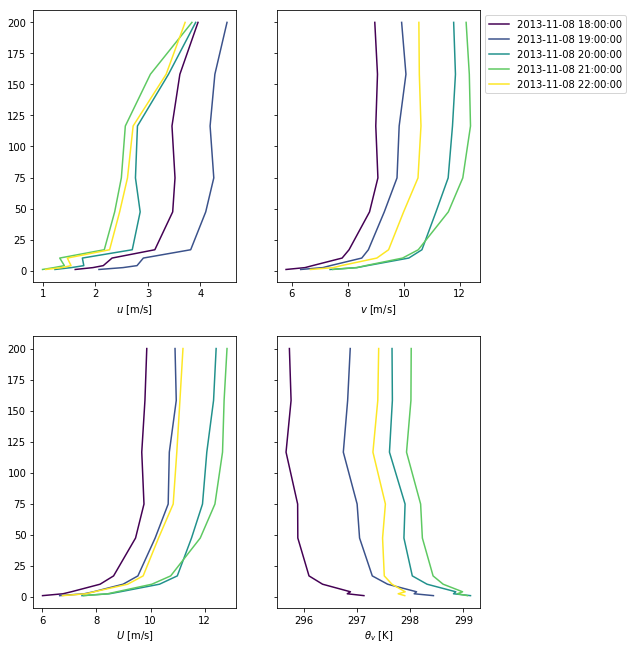

In [35]:
fig,ax = plt.subplots(nrows=2,ncols=2,sharey=True,figsize=(8,11))
cmap = get_cmap('viridis')
times_in_range = times[(times >= '2013-11-08 18:00') & (times <= '2013-11-08 22:00')]
for itime,time in enumerate(times_in_range):
    if not itime % 6 == 0:
        continue
    color = cmap(itime/(len(times_in_range)-1))
    df_i = df_10min.loc[df_10min.index==time]
    Umag = np.sqrt(df_i['u']**2 + df_i['v']**2 + df_i['w']**2)
    ax[0,0].plot(df_i['u'],df_i['height'],color=color)
    ax[0,1].plot(df_i['v'],df_i['height'],label=str(time),color=color)
    ax[1,0].plot(Umag,df_i['height'],color=color)
    ax[1,1].plot(df_i['thetav'],df_i['height'],color=color)
ax[0,0].set_xlabel(r'$u$ [m/s]')
ax[0,1].set_xlabel(r'$v$ [m/s]')
ax[1,0].set_xlabel(r'$U$ [m/s]')
ax[1,1].set_xlabel(r'$\theta_v$ [K]')
ax[0,1].legend(loc='upper left',bbox_to_anchor=(1,1))